# Developing xspec spectral models
Whether you are proposing a new spectral model for inclusion in XSPEC, developing a separate package that extends XSPEC's capabilities, or implementing custom models for your own astrophysical research projects, this guide details how to develop components that integrate seamlessly with XSPEC's analysis tools and frameworks.

By following these guidelines, you can ensure that your spectral models are compatible with XSPEC's architecture, allowing them to be used effectively within XSPEC's environment for fitting astronomical data, performing statistical analysis, and contributing to the broader astrophysical community's research efforts.

# Base_Spec_Model Class Overview with Examples

The `Base_Spec_Model` class is designed as a foundation for implementing spectral models in astrophysical data analysis, particularly for the XSPEC framework. Below, we provide a brief overview of each method within this class along with example code snippets to illustrate their usage.

## Constructor: `__init__(self, params_list)`

The constructor initializes a spectral model with a set of parameters. Each parameter in the `params_list` can be either continuous or discrete:

- **Continuous Parameters**: Defined as tuples with the format `(initial value, lower bound, upper bound)`.
- **Discrete Parameters**: Directly specified without a tuple format.

The constructor also uniquely names each instance of a subclass by appending a count to the class name, allowing for multiple distinct instances of the same model within an analysis.

### Key Features:

- **Parameter Normalization**: Continuous parameters are normalized, ensuring they are within a specified range.
- **Unique Parameter Naming**: Each parameter is uniquely named by prefixing it with the instance name, facilitating differentiation between multiple instances of models.

### Example:

This initializes a model instance with two possible parameter sets, each specifying a thickness range and a discrete model type.

In [1]:
from xspec.models import Base_Spec_Model
params_list = [
    {'thickness': (5.0, 1.0, 10.0), 'model_type': 'A'},  # Continuous and discrete parameters
    {'thickness': (7.0, 1.0, 15.0), 'model_type': 'B'}   # Thickness is continuous and assign a tuple 
                                                         # in format (init_values, min, max).
]
model = Base_Spec_Model(params_list)

## Method: `forward(self, energies)`

A placeholder method meant to be overridden in subclasses, defining how the model computes its output given an input tensor of energies.

### Example:

This example shows a custom model that squares the input energies, showcasing how one might implement the `forward` method.

* Notice that, this should be a function of energies dependent on parameters defined in params_list.

In [2]:
import torch
class MySpecModel(Base_Spec_Model):
    def __init__(self, model_types, thickness):
        """A template customer model.

        Args:
            model_types (list): A list of possible model types.
            thickness (tuple): (initial value, lower bound, upper bound) for the thickness.
                These three values cannot be all None. It will not be optimized when lower == upper.
        """
        # Specify key word for this specific model. Each element corresponds to one possible parameters combination.
        params_list = [{'model_type': mt, 'thickness': thickness} for mt in model_types]
        # Base_Spec_Model __init__
        super().__init__(params_list)
    def forward(self, energies):
        # Example computation: simply return the square of the input energies
        return energies ** 2

# Assuming 'energies' is a tensor of X-ray energies
energies = torch.tensor([1.0, 2.0, 3.0])
my_model = MySpecModel(model_types=['A', 'B', 'C'], thickness = (2, 1, 5))
output = my_model(energies)
print('energies:', energies)
print('output:', output)

energies: tensor([1., 2., 3.])
output: tensor([1., 4., 9.])


## Method: `get_params(self)`

Retrieves the current parameter estimates, useful for inspection or analysis.

### Example:
This would print the current parameter estimates, including the denormalized and clamped values for continuous parameters.

In [3]:
current_params = my_model.get_params()
print(current_params)

{'MySpecModel_1_model_type': 'A', 'MySpecModel_1_thickness': tensor(2., grad_fn=<ClampFunctionBackward>)}


## Method: `set_params(self, params)`

Updates the model's parameters based on a provided dictionary, allowing for dynamic adjustment during analysis.

### Example:

This example demonstrates updating the model's temperature range and model type parameters.

In [4]:
new_params = {'MySpecModel_2_thickness': (6.0, 1.0, 12.0), 'MySpecModel_2_model_type': 'C'}
my_model.set_params(new_params)
current_params = my_model.get_params()
print(current_params)

{'MySpecModel_1_model_type': 'A', 'MySpecModel_1_thickness': tensor(2., grad_fn=<ClampFunctionBackward>)}


# Case Study: Creating a Filter Model with `Base_Spec_Model`

In this case study, we explore the implementation of a filter model using the `Base_Spec_Model` class as a foundation. This model simulates the behavior of X-ray filters using Beer's Law, leveraging the mass attenuation coefficients from NIST to predict how different materials and thicknesses attenuate X-ray energies.

## Beer's Law

Beer's Law, also known as Beer-Lambert Law, is a key principle in spectroscopy and radiography, describing the attenuation of light (or X-ray) through a medium. The law is mathematically represented as:

$I = I_0 e^{-\mu x}$

where:
- $I$ is the intensity of the X-ray after passing through the material,
- $I_0$ is the initial intensity of the X-ray before it enters the material,
- $\mu$ is the linear attenuation coefficient of the material, which depends on the energy of the X-ray and the material's properties,
- $x$ is the thickness of the material.


## The `Filter` Model

The `Filter` class follows `Base_Spec_Model`, incorporating materials and their thickness to calculate the filter response based on Beer's Law. It is designed to accept a list of materials and a tuple specifying the thickness range for the filter.

### Implementation Details

- **Materials**: The model accepts a list of possilbe `Material` instances, each defined by a chemical formula and density. These materials represent the possible choices for the filter's composition.
- **Thickness**: The filter's thickness is specified as a tuple `(initial value, lower bound, upper bound)`, guiding the optimization process and ensuring the physical plausibility of the model.

#### Fit custer input argument to `Base_Spec_Model`
```python
params_list = [{'material': mat, 'thickness': thickness} for mat in materials]
```

### Forward Method

The `forward` method calculates the filter response for a given range of X-ray energies, utilizing the `gen_fltr_res` function. This function applies Beer's Law to determine how the selected material and its thickness attenuate the X-ray energies.

#### 1. Read parameters.

```python
mat = self.get_params()[f"{self.prefix}_material"]
th = self.get_params()[f"{self.prefix}_thickness"]
```
#### 2. Call filter response function
```python
gen_fltr_res(energies, mat, th)
```

In [6]:
import numpy as np
import torch
from xspec import Material
from xspec.chem_consts import get_lin_att_c_vs_E
from xspec.models import Base_Spec_Model

def gen_fltr_res(energies, fltr_mat: Material, fltr_th: float):
    # thickness is in mm
    mu = get_lin_att_c_vs_E(fltr_mat.density, fltr_mat.formula, energies)
    mu = torch.tensor(mu, dtype=torch.float)
    att = torch.exp(-mu * fltr_th)

    return att


class Filter(Base_Spec_Model):
    def __init__(self, materials, thickness):
        """
        A template filter model based on Beer's Law and NIST mass attenuation coefficients, including all necessary methods.

        Args:
            materials (list): A list of possible materials for the filter,
                where each material should be an instance containing formula and density.
            thickness (tuple): (initial value, lower bound, upper bound) for the filter thickness (mm).
                These three values cannot be all None. It will not be optimized when lower == upper.
        """
        params_list = [{'material': mat, 'thickness': thickness} for mat in materials]
        super().__init__(params_list)

    def forward(self, energies):
        """
        Takes X-ray energies and returns the filter response.

        Args:
            energies (torch.Tensor): A tensor containing the X-ray energies of a poly-energetic source in units of keV.

        Returns:
            torch.Tensor: The filter response as a function of input energies, selected material, and its thickness.
        """
        mat = self.get_params()[f"{self.prefix}_material"]
        th = self.get_params()[f"{self.prefix}_thickness"]
        # print('ID filter th:', id(th))
        return gen_fltr_res(energies, mat, th)

{'Filter_1_material': Material(formula='Al', density=2.702),
 'Filter_1_thickness': tensor(5., grad_fn=<ClampFunctionBackward>)}


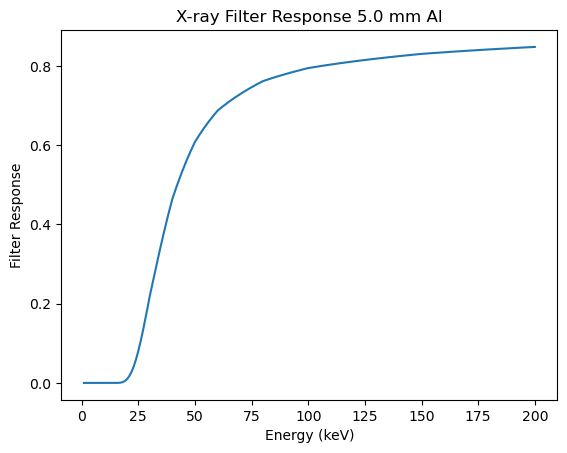

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pprint


psb_fltr_mat = [Material(formula='Al', density=2.702), Material(formula='Cu', density=8.92)]
filter_1 = Filter(materials = psb_fltr_mat, thickness=(5, 0, 10))
params = filter_1.get_params()
pprint.pprint(params)
with torch.no_grad():
    energies = np.linspace(1, 200, 200)  # X-ray energies from 1 to 200 keV
    plt.plot(energies, filter_1(energies))  # Plotting the filter response
    plt.xlabel('Energy (keV)')
    plt.ylabel('Filter Response')
    plt.title(f'X-ray Filter Response {params[f"{filter_1.prefix}_thickness"].numpy()} mm {params[f"{filter_1.prefix}_material"].formula}')
    plt.show()
    